# Peer-to-peer Lending Risk and Return Analysis Using Lending Club Data
Peer-to-peer (P2P) lending is a new financial lending mode developed recently. It has several advantage compared to conventional financial mode. For borrowers, application and approval process is largely reduced and interest rate can be better compared to conventional loan from financial organization. For lenders, investment return can have a good rate compared to traditional saving or CD account and lenders can choose borrowers based on their analysis. For an investment, the most critical concern is that the loan is safe or not. Using Lending Club data, we build multiple models to analyze the load rist and investment return. 
#### Highlight:
**1. Data cleaning and feature engineering:**  In this part, data was load and cleaned. Certain features with more than 90% empty entry are discarded. Duplicate or highly correlated data are removed to save time and space. 

**2. Data exploration and visualization:**  In this part, multiple techniques are used to explore and virsualize data. Based on the data exporation and visualization, relationship between the important feature and loan status are studied. 

**3. Pre- Machine Learning data engineering:**  In this part, engineered data are further processed into the format that are ready for machine learning training and testing. For simplicity and time concern, only the features that are explored in previous part are chosen. Numerical features are keep as same, catagorical features are encoded. 

**4. Building different models and compare:**  In this part, different calssification models are used to predict a bad loan. SMOTE is used to re-blance the imblance data. Using XGBOOST, accuracy of 84% and recall of 95% can be achieved on the test data set.

**5. Develop a simple neural network and implement the above data:**  In this part, a simple neural network is writtern from scrach using back propangation algorithm. The network employs one hidden with 200 hidden nodes. Accuracy of 76% can be achieved using this self-writtern neural network. 

**6. Develope a real neural network with 2 hidden layers using Tensorflow:**  In this part, a real neural network was developed using Tensorflow. The network employs 2 hidden layers with 500 and 750 hidden  nodes, repectively. Sigmoid cross entropy is used to calculate cost. With this neural network, accuray of 82% can be achieved. 

**7. Consider from a different side: Building a regression model for investment return:**  In this part, different from previous parts which build classification models using different methods, a regression model is built to differenciate bad loans from the good ones using investment return as a indicator. With an extra threshold parameter added in to the RandomForest regressor model, different investment return rate can be achieved. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

Load data and data dictionary. Format the display option, so that we can visually exam the data dictionary

In [2]:
raw_data = pd.read_csv('./data/loan.csv')
data_dic = pd.read_excel('./data/LCDataDictionary.xlsx', sheetname = 'LoanStats')
pd.set_option('display.max_colwidth', -1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Examing the data summary below, we can see that there are totally 74 features provided bu Lending Club. However, a number of feautures are not quite useful for our modeling purpose.

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

Drop useless features and the features that more than 90% of entries are NA. After this step of filtering, only 49 features are left.

In [4]:
data_reduced = raw_data.drop(['id', 'member_id', 'emp_title', 'url', 'title', 'last_pymnt_d', 'next_pymnt_d', 
                              'desc'], axis=1)

data_reduced.dropna(axis=1, thresh=88000, inplace=True)
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 49 columns):
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status                    887379 non-null object
pymnt_plan                     887379 non-null object
purpose                        887379 non-null object
zip_code           

Double check the deleted features from feature dictionary to make sure no critical features are deleted by mistake

In [5]:
full_list_name = list(raw_data)
reduced_list_name = list(data_reduced)
removed_col = np.setdiff1d(full_list_name,reduced_list_name)
data_dic[data_dic['LoanStatNew'].isin(removed_col)]

,LoanStatNew,Description
3,all_util,Balance to credit limit on all trades
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
15,desc,Loan description provided by the borrower
17,dti_joint,"A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income"
20,emp_title,The job title supplied by the Borrower when applying for the loan.*
27,id,A unique LC assigned ID for the loan listing.
28,il_util,Ratio of total current balance to high credit/credit limit on all install acct
30,inq_fi,Number of personal finance inquiries
31,inq_last_12m,Number of credit inquiries in past 12 months
40,last_pymnt_d,Last month payment was received


There are a number of features having a large amount of NAs, They are mainly the month data. Fill the NA months with a value of 5 years

In [6]:
data_reduced['mths_since_last_delinq'].fillna(value = 120, inplace = True)
data_reduced['mths_since_last_record'].fillna(value = 120, inplace = True)
data_reduced['mths_since_last_major_derog'].fillna(value = 120, inplace = True)
data_reduced['mths_since_last_major_derog'].fillna(value = 120, inplace = True)

data_reduced.dropna(axis=0, how='any', inplace = True)
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816673 entries, 42535 to 887378
Data columns (total 49 columns):
loan_amnt                      816673 non-null float64
funded_amnt                    816673 non-null float64
funded_amnt_inv                816673 non-null float64
term                           816673 non-null object
int_rate                       816673 non-null float64
installment                    816673 non-null float64
grade                          816673 non-null object
sub_grade                      816673 non-null object
emp_length                     816673 non-null object
home_ownership                 816673 non-null object
annual_inc                     816673 non-null float64
verification_status            816673 non-null object
issue_d                        816673 non-null object
loan_status                    816673 non-null object
pymnt_plan                     816673 non-null object
purpose                        816673 non-null object
zip_code       

Split catagorical and numeric features. Generate correlation matrix for numeric features to remove highly correlated features. We can see some highly correlated features, such as funded_amnt and funded_amnt_inv. In order to save time and space, we discard these features. After the operation, we can see that no more features having highly correlations. 

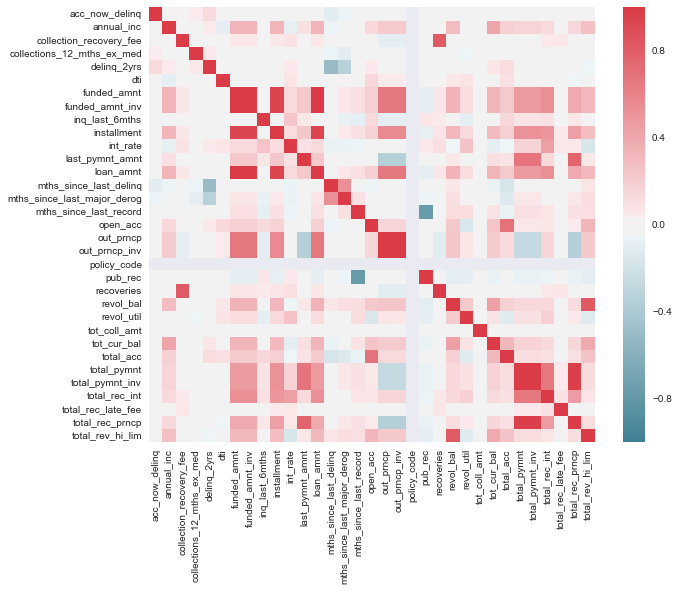

In [7]:
col_list = list(data_reduced)
catagorical_list = ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status'
                   'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 
                    'last_credit_pull_d', 'application_type']
numeric_list = np.setdiff1d(col_list, catagorical_list)

data_numeric = data_reduced[numeric_list]
f, ax = plt.subplots(figsize=(10, 8))
corr = data_numeric.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)

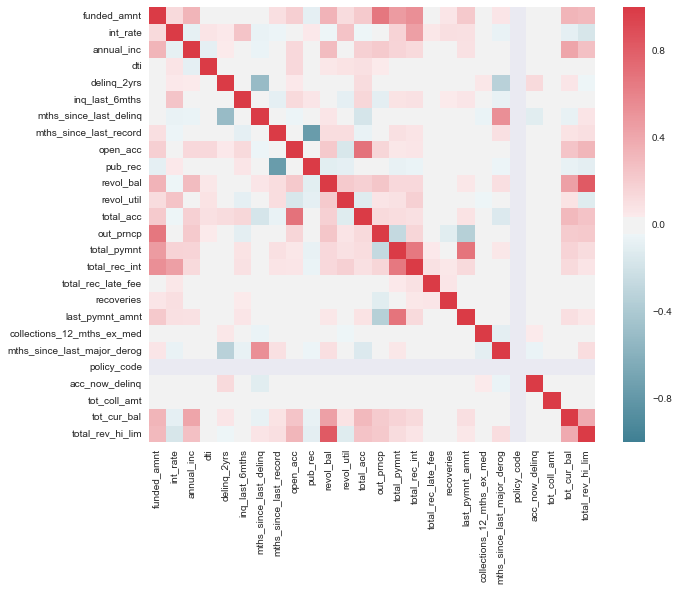

In [8]:
data_reduced.drop(['collection_recovery_fee', 'funded_amnt_inv', 'installment', 'total_pymnt_inv', 'loan_amnt',
                   'total_rec_prncp', 'sub_grade', 'purpose', 'zip_code', 'earliest_cr_line', 'initial_list_status',
                   'application_type', 'out_prncp_inv', 'pymnt_plan'], axis = 1, inplace = True)

col_list = list(data_reduced)

f, ax = plt.subplots(figsize=(10, 8))
corr = data_reduced.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)

After the data cleaning in above steps, final data set that will be used in the modeling is as below.

In [9]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816673 entries, 42535 to 887378
Data columns (total 35 columns):
funded_amnt                    816673 non-null float64
term                           816673 non-null object
int_rate                       816673 non-null float64
grade                          816673 non-null object
emp_length                     816673 non-null object
home_ownership                 816673 non-null object
annual_inc                     816673 non-null float64
verification_status            816673 non-null object
issue_d                        816673 non-null object
loan_status                    816673 non-null object
addr_state                     816673 non-null object
dti                            816673 non-null float64
delinq_2yrs                    816673 non-null float64
inq_last_6mths                 816673 non-null float64
mths_since_last_delinq         816673 non-null float64
mths_since_last_record         816673 non-null float64
open_acc     

#### 2. Data exploration and visualization
For the good and bad loan classification, we choose the loan status as the label column. Among all the data entries, "Fully paid" will be classified as good loan since the loans are paid off. "Charged off", "Late" and "Default" will be classicied as bad loan. Although the "Late" status is not finally concluded yet, we still consider this as risky loan. 

Unfortunately, the majority of the data entries are "Current", on which we cannot draw a conclution yet. For simplicity, we will not use these loans for classification modeling. For the part 7, the regression modeling, we may be able to use some of the current loans, and if I have time some projection can be made on the current loans that are almost fully paied.  

In [10]:
data_reduced['loan_status'].value_counts()

Current               597918
Fully Paid            153923
Charged Off           35201 
Late (31-120 days)    11461 
Issued                8457  
In Grace Period       6185  
Late (16-30 days)     2328  
Default               1200  
Name: loan_status, dtype: int64

In [11]:
def status_label(status):
    if status == 'Fully Paid':
        return 0
    else:
        return 1

In [12]:
filter_mask = data_reduced['loan_status'].isin(['Fully Paid', 'Charged Off', 'Late (31-120 days)', 
                                                'Late (16-30 days)', 'Default'])
data_final = data_reduced[filter_mask]
temp = data_final.copy()
temp['loan_label'] = data_final['loan_status'].apply(status_label)
data_final = temp
data_final.drop('loan_status', axis = 1, inplace=True)

Below are the final data entries that will be used in modeling. Note that the data are highly imblance -- the negative data volume is 3 times larger than that of positive data. 

In [13]:
data_final['loan_label'].value_counts()

0    153923
1    50190 
Name: loan_label, dtype: int64

#### Below we will do some feature engineering, as well as data exploration and visualization
**Issue Date:** We translate the original issue date into month, group the funded amount by month and plot them. As we can see, total funded amount experienced a growing period from 2013 to 2015, then gradually drop since 2015. One reason of the decline can be that investors are more careful in lending the money. Or Lending Club may not be doing their business well recently. 

In [14]:
data_final['issue_date'] = pd.to_datetime(data_final['issue_d'])
data_final.drop('issue_d', axis = 1, inplace = True)
data_final['issue_month'] = data_final['issue_date'].apply(lambda x: x.to_period('M'))
data_final.head(5)

,funded_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,addr_state,dti,...,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_label,issue_date,issue_month
42538,12000.0,36 months,13.53,B,10+ years,RENT,40000.0,Source Verified,NM,16.94,...,0.0,53.0,1.0,0.0,15386.0,13605.0,8100.0,0,2013-12-01,2013-12
42544,3000.0,36 months,12.85,B,10+ years,RENT,25000.0,Verified,FL,24.68,...,0.0,69.0,1.0,0.0,154.0,19530.0,5300.0,0,2013-12-01,2013-12
42546,28000.0,36 months,7.62,A,5 years,MORTGAGE,325000.0,Source Verified,CA,18.55,...,0.0,120.0,1.0,0.0,0.0,799592.0,54200.0,0,2013-12-01,2013-12
42549,24000.0,36 months,13.53,B,10+ years,MORTGAGE,100000.0,Verified,MI,22.18,...,0.0,120.0,1.0,0.0,539.0,199834.0,28200.0,0,2013-12-01,2013-12
42550,8000.0,36 months,10.99,B,2 years,MORTGAGE,33000.0,Not Verified,CO,15.75,...,0.0,120.0,1.0,0.0,0.0,15949.0,20800.0,1,2013-12-01,2013-12


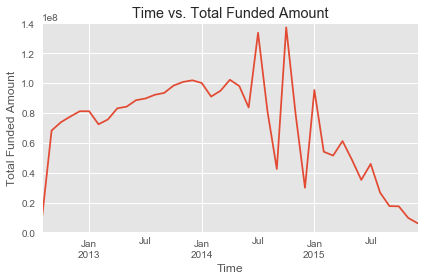

In [15]:
data_group_by_month = data_final[['issue_month', 'funded_amnt']].groupby('issue_month').sum()

plt.style.use('ggplot')
data_group_by_month['funded_amnt'].plot()
plt.ylim([0, 1.4e8])
plt.xlabel('Time')
plt.ylabel('Total Funded Amount')
plt.title('Time vs. Total Funded Amount')
plt.tight_layout()

**State:** We group the funded amount by address state. As we can see, CA, NY, TX and FL are the top states that money was lending to. It is because of the high population of these states. From the average loan status (0 for good loan, 1 for bad loans), the overall values for each states are around 0.2. There is no clear state dependency. 

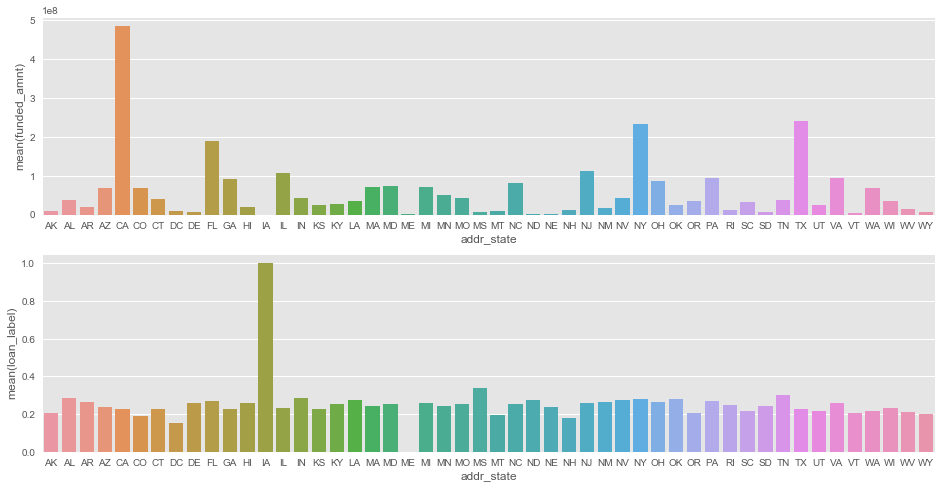

In [16]:
funded_amnt_group_by_state = data_final[['addr_state', 'funded_amnt']].groupby(['addr_state'], as_index = False).sum()
loan_label_group_by_state = data_final[['addr_state', 'loan_label']].groupby(['addr_state'], as_index = False).mean()

f, (ax1, ax2) = plt.subplots(2, 1, sharex=False, figsize = (16, 8))
sns.barplot(ax=ax1, x='addr_state', y='funded_amnt', data=funded_amnt_group_by_state)
sns.barplot(ax=ax2, x='addr_state', y='loan_label', data=loan_label_group_by_state)

**Term and Grade:** First, let's look at the grade of the loan. The load label has strong dependency on the grade of the loan. If the grade is rated as "A", we have only 10% or less chance to have a bad loan. The the grade degrade, the percentage of bad loans increase nomolitically. If the grade is rated as "G", the chace of bad loans are more than 50%. We we make a decision on lending money, we should carefully consider the grade. Second, let's look at the term. For relatively good grade (A to E), 60 month term always has higher chance of violation than short term (36 month). When grade are bad (F, G) the percentage of bad loans are equally high in both long and short terms. 

In [17]:
data_group_by_grade_term = data_final[['term', 'grade', 'int_rate']].groupby(['term', 'grade']).mean().reset_index()
data_group_by_grade_term.pivot(index='term', columns='grade', values='int_rate')

grade,A,B,C,D,E,F,G
term,,,,,,,
36 months,7.548021,11.582149,14.622489,17.795392,20.556489,24.019675,26.069375
60 months,8.557269,11.417472,14.960791,17.679377,20.737113,24.011227,25.859587


In [18]:
loan_label_group_by_grade_term = data_final[['term', 'grade', 'loan_label']].groupby(['term', 'grade']).mean().reset_index()
loan_label_group_by_grade_term.pivot(index='term', columns='grade', values='loan_label')

grade,A,B,C,D,E,F,G
term,,,,,,,
36 months,0.082167,0.158197,0.24294,0.318228,0.394697,0.462252,0.513889
60 months,0.126882,0.201595,0.30056,0.382023,0.433964,0.467410,0.510613


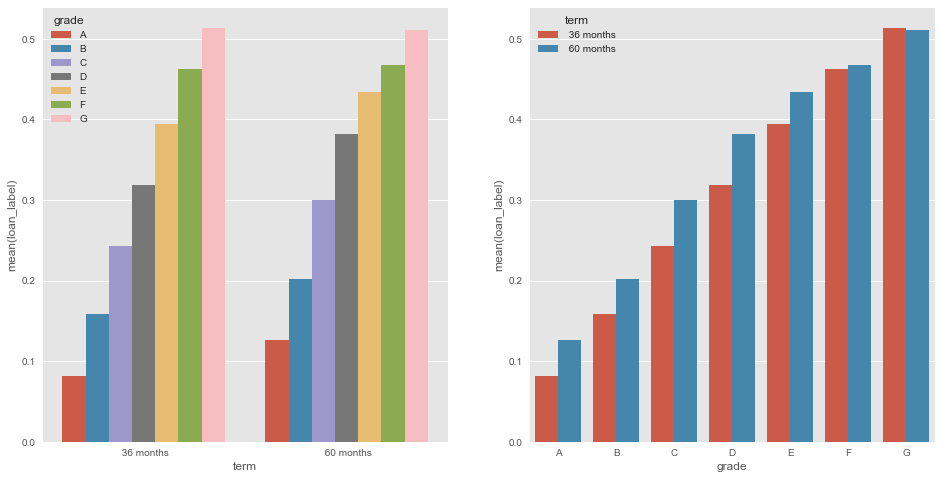

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize = (16, 8))
sns.barplot(ax=ax1, x='term', y='loan_label', hue='grade', data=loan_label_group_by_grade_term)
sns.barplot(ax=ax2, x='grade', y='loan_label', hue='term', data=loan_label_group_by_grade_term)

**Employment length:** Define a function to encode the string employment length into numerical numbers 0.5 to 10. From the average funded amount we can see that people tend not to lend money to people with less than 1 year employment or employment length is not available. And indeed, people with less than 1 year employment or employment length is not available show much higher chance of loan violation. For the people with 10+ year employment length, the chance for bad loan are significantly lower. 

In [20]:
def proc_emp_length(emp_length_val):
    if emp_length_val == '< 1 year' or emp_length_val == 'n/a':
        emp_length_feat = 0.5
    elif emp_length_val == '10+ years':
        emp_length_feat = 10
    else:
        emp_length_feat = float(emp_length_val.rstrip(' years'))
    return emp_length_feat

temp = data_final.copy()
temp['employment_length'] = data_final['emp_length'].apply(proc_emp_length)
data_final = temp
data_final.drop('emp_length', axis = 1, inplace=True)

(0.2, 0.3)

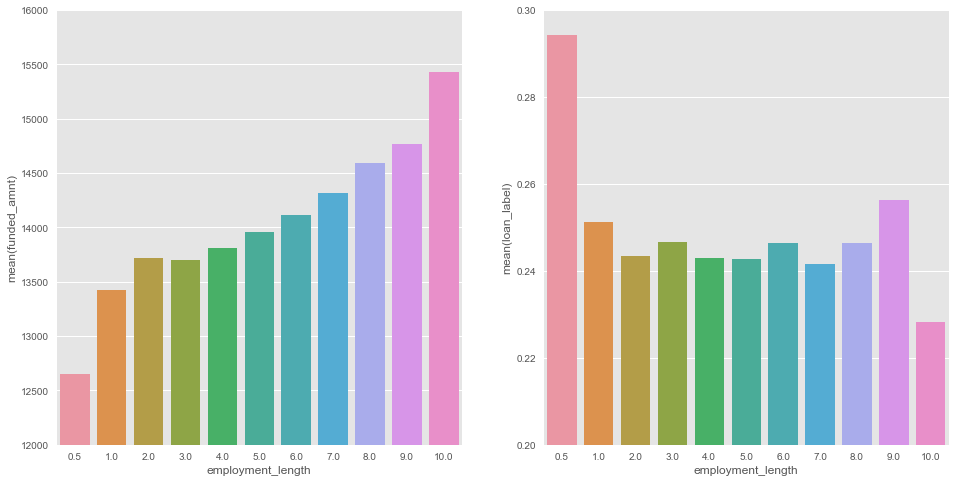

In [21]:
loan_label_group_by_emp_length = data_final[['employment_length', 'loan_label']].groupby(['employment_length'], 
                                                                                         as_index = False).mean()
funded_amnt_group_by_emp_length = data_final[['employment_length', 'funded_amnt']].groupby(['employment_length'], 
                                                                                         as_index = False).mean()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 8))
sns.barplot(ax=ax1, x='employment_length', y='funded_amnt', data=funded_amnt_group_by_emp_length)
sns.barplot(ax=ax2, x='employment_length', y='loan_label', data=loan_label_group_by_emp_length)

ax1.set_ylim([12000, 16000])
ax2.set_ylim([0.2, 0.3])

**Funded amount and Annual income:** From the first figure below we can see that for the good loans (label 0), the median annual income is higher than that of the bad loans (label 1), smaller funded amount has lower chance to have bad loans. So in reality, it is better for an investor to spead money into multiple smaller loans instead of single big loans. A more meaningful feature could be the normalized funded amount to annual income. As we can see from the third figure below, good loans and bad loans are more differencaited if we consider normalized funded amount. 

In [22]:
data_final['norm_funded_amnt'] = data_final['funded_amnt']/data_final['annual_inc']
data_final.head(5)

,funded_amnt,term,int_rate,grade,home_ownership,annual_inc,verification_status,addr_state,dti,delinq_2yrs,...,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,loan_label,issue_date,issue_month,employment_length,norm_funded_amnt
42538,12000.0,36 months,13.53,B,RENT,40000.0,Source Verified,NM,16.94,0.0,...,1.0,0.0,15386.0,13605.0,8100.0,0,2013-12-01,2013-12,10.0,0.300000
42544,3000.0,36 months,12.85,B,RENT,25000.0,Verified,FL,24.68,0.0,...,1.0,0.0,154.0,19530.0,5300.0,0,2013-12-01,2013-12,10.0,0.120000
42546,28000.0,36 months,7.62,A,MORTGAGE,325000.0,Source Verified,CA,18.55,0.0,...,1.0,0.0,0.0,799592.0,54200.0,0,2013-12-01,2013-12,5.0,0.086154
42549,24000.0,36 months,13.53,B,MORTGAGE,100000.0,Verified,MI,22.18,0.0,...,1.0,0.0,539.0,199834.0,28200.0,0,2013-12-01,2013-12,10.0,0.240000
42550,8000.0,36 months,10.99,B,MORTGAGE,33000.0,Not Verified,CO,15.75,0.0,...,1.0,0.0,0.0,15949.0,20800.0,1,2013-12-01,2013-12,2.0,0.242424


(0, 200000.0)

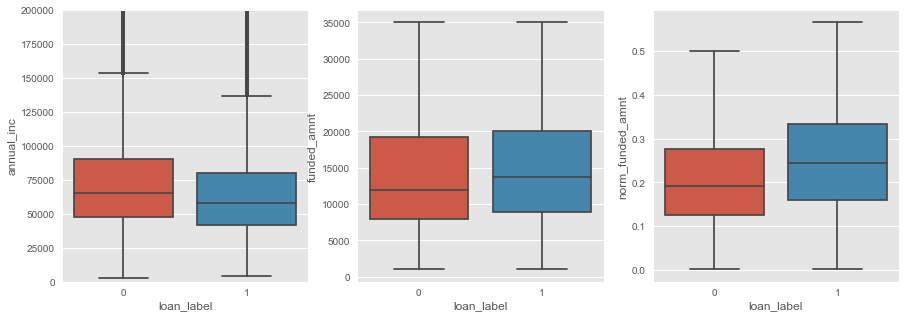

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
sns.boxplot(ax=ax1, x='loan_label', y='annual_inc', data=data_final[['loan_label', 'annual_inc']])
sns.boxplot(ax=ax2, x='loan_label', y='funded_amnt', data=data_final[['loan_label', 'funded_amnt']])
sns.boxplot(ax=ax3, x='loan_label', y='norm_funded_amnt', data=data_final[['loan_label', 'norm_funded_amnt']])

ax1.set_ylim([0, 0.02e7])

**Home ownership:** Home ownership with "other" status seems to have much lower chance of bad loans. However, as we examime the count, we see the count for "other" status is much lower, so the average loan label for this status is not quite useful. Among all other 3 statuses, "Mortgage", "Own" and "Rent", people have morgage has lowest chace to violate loan, people who are renting have highest percentage. 

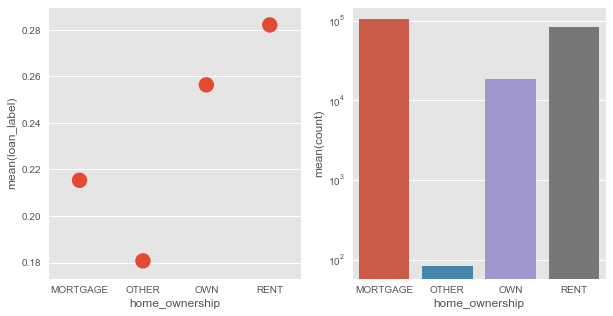

In [24]:
data_final['home_ownership'].replace('ANY', 'OTHER', inplace=True)
data_final['home_ownership'].replace('NONE', 'OTHER', inplace=True)

data_group_by_home = data_final[['home_ownership', 'loan_label']].groupby('home_ownership').mean()
data_group_by_home['count'] = data_final[['home_ownership', 'loan_label']].groupby('home_ownership').count()
data_group_by_home.reset_index(inplace = True)

f, (ag1, ag2) = plt.subplots(1, 2, figsize = (10, 5))
sns.pointplot(ax = ag1, x = 'home_ownership', y = 'loan_label', data = data_group_by_home, join = False, scale = 1.5)
sns.barplot(ax = ag2, x = 'home_ownership', y = 'count', data = data_group_by_home)

ag2.set_yscale('log')

**Verification Status:** In the data set, "verified", "not verified" and "source verified" almost have same counts. Among the 3 status, "Not verified" have lowest chance for bad loan. This doesn't seem to be quite reasonable to me. Need to do more investigation on this if I have time.

In [25]:
data_final['verification_status'].value_counts()

Verified           77811
Source Verified    63535
Not Verified       62767
Name: verification_status, dtype: int64

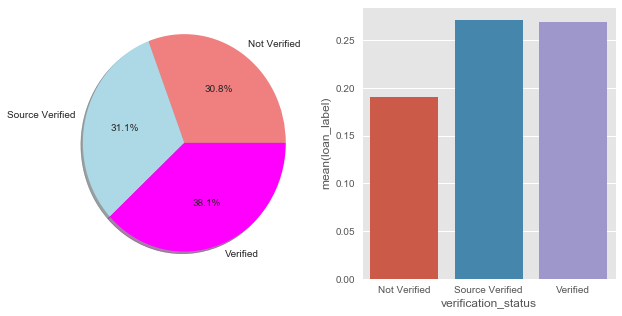

In [26]:
data_group_by_verification = data_final[['verification_status', 'loan_label']].groupby('verification_status', 
                                                                                       as_index = False).count()

label_group_by_verification = data_final[['verification_status', 'loan_label']].groupby('verification_status', 
                                                                                       as_index = False).mean()

labels = data_group_by_verification['verification_status'].tolist()
sizes = data_group_by_verification['loan_label'].tolist()
colors = ['lightcoral', 'lightblue', 'magenta']
          
f, (ap1, ap2) = plt.subplots(1, 2, figsize = (10, 5))
          
ap1.pie(sizes, labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True)
sns.barplot(ax = ap2, x = 'verification_status', y = 'loan_label', data = label_group_by_verification)

#### 3. Pre- Machine Learning data processing
Final check the summary of the data for maching learning modeling

In [27]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204113 entries, 42538 to 887371
Data columns (total 37 columns):
funded_amnt                    204113 non-null float64
term                           204113 non-null object
int_rate                       204113 non-null float64
grade                          204113 non-null object
home_ownership                 204113 non-null object
annual_inc                     204113 non-null float64
verification_status            204113 non-null object
addr_state                     204113 non-null object
dti                            204113 non-null float64
delinq_2yrs                    204113 non-null float64
inq_last_6mths                 204113 non-null float64
mths_since_last_delinq         204113 non-null float64
mths_since_last_record         204113 non-null float64
open_acc                       204113 non-null float64
pub_rec                        204113 non-null float64
revol_bal                      204113 non-null float64
revol_util

**Selecting features:** Because the project is written and run on my laptop, for simplicity and in order to save time and space, simply choose the features we have explored above. Will use the full feature set if I have time. 

In [28]:
numeric_col = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 
                'mths_since_last_record', 'employment_length', 'norm_funded_amnt']
categorical_col = ['term', 'grade', 'home_ownership', 'verification_status', 'addr_state']
label_col = ['loan_label']

numeric_short = data_final[numeric_col].values
categorical_short = data_final[categorical_col].values

In [29]:
print('Numeric features number: ' + str(numeric_short.shape[1]))
print('Categorical features number: ' + str(categorical_short.shape[1]))
print('Total data points: ' + str(numeric_short.shape[0]))

Numeric features number: 9
Categorical features number: 5
Total data points: 204113


**Encode the catagorical features:** Method 1: Use OnehotEncoder to trasform the data into numpy array

In [30]:
X = numeric_short
y = data_final[label_col].values

for n in range(categorical_short.shape[1]):
    label_enc = preprocessing.LabelEncoder()
    label_val = label_enc.fit_transform(categorical_short[:,n])
    label_val = label_val.reshape(-1, 1)

    onehot_enc = preprocessing.OneHotEncoder()
    category_temp = onehot_enc.fit_transform(label_val)
    category_temp = category_temp.toarray()
    
    X = np.hstack((X, category_temp))

In [31]:
X.shape

(204113, 75)

Split the data into training and testing sets by 2/3 and 1/3. 

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/3, random_state=42)

**Encode the catagorical features:** Method 2: Use get_dummies to keep the data as pandas dataframe

In [33]:
X_df = data_final[categorical_col + numeric_col]

In [34]:
X_df.head(5)

,term,grade,home_ownership,verification_status,addr_state,funded_amnt,int_rate,annual_inc,dti,delinq_2yrs,mths_since_last_delinq,mths_since_last_record,employment_length,norm_funded_amnt
42538,36 months,B,RENT,Source Verified,NM,12000.0,13.53,40000.0,16.94,0.0,53.0,33.0,10.0,0.300000
42544,36 months,B,RENT,Verified,FL,3000.0,12.85,25000.0,24.68,0.0,58.0,53.0,10.0,0.120000
42546,36 months,A,MORTGAGE,Source Verified,CA,28000.0,7.62,325000.0,18.55,0.0,120.0,120.0,5.0,0.086154
42549,36 months,B,MORTGAGE,Verified,MI,24000.0,13.53,100000.0,22.18,0.0,120.0,120.0,10.0,0.240000
42550,36 months,B,MORTGAGE,Not Verified,CO,8000.0,10.99,33000.0,15.75,0.0,120.0,104.0,2.0,0.242424


In [35]:
for feature in categorical_col:
    
    X_df_temp = pd.get_dummies(X_df[feature])
    X_df = X_df.merge(X_df_temp, left_index = True, right_index = True)
    X_df.drop(feature, axis = 1, inplace = True)
y_df = data_final[label_col]

Examine the dataframe generated by the second method. The column number is same as the one generated by method 1. By doign this,  doube confirm the data encoding is correct. 

In [36]:
X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204113 entries, 42538 to 887371
Data columns (total 75 columns):
funded_amnt               204113 non-null float64
int_rate                  204113 non-null float64
annual_inc                204113 non-null float64
dti                       204113 non-null float64
delinq_2yrs               204113 non-null float64
mths_since_last_delinq    204113 non-null float64
mths_since_last_record    204113 non-null float64
employment_length         204113 non-null float64
norm_funded_amnt          204113 non-null float64
 36 months                204113 non-null uint8
 60 months                204113 non-null uint8
A                         204113 non-null uint8
B                         204113 non-null uint8
C                         204113 non-null uint8
D                         204113 non-null uint8
E                         204113 non-null uint8
F                         204113 non-null uint8
G                         204113 non-null uint8
MOR

#### 4. Building different models and compare

**Logistic Regression with original data:** Building a logistic regression model using the original data that are generated by method 1 above. Use the grid search and 10 fold cross validation to achieve the best hyper parameter. Use accuracy as the metrics to evaluate different hyper parameters. 

accuracy = (tp + tn)/(tp + tn + fp + fn)

precision = tp/(tp + fp)

recall = tp/(tp + fn)

Note that, in our data set, bad loan is positive, good loan is negative. Among all the above 3 metrics, for our purpose recall is the most important one. Because there will be significant financail loss if we predict a posive entry as negative. 

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

lr_model = LogisticRegression()
parameters = {'C': [0.1, 1, 10]}

acc_scorer = metrics.make_scorer(metrics.accuracy_score)

grid_obj = GridSearchCV(lr_model, param_grid = parameters, scoring = acc_scorer, cv = 10)
grid_obj = grid_obj.fit(X_train, y_train[:,0])

lr_model = grid_obj.best_estimator_

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy = metrics.accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test, pos_label=1)
recall = metrics.recall_score(y_pred, y_test, pos_label=1)

print("Best parameters set for Logistic Regression found as follows:")
print()
print(grid_obj.best_estimator_)
print()
#print("Grid scores:")
#for params, mean_score, scores in grid_obj.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() / 2, params))
#print()

print('accuracy = ' + str(accuracy))
print('precision = ' + str(precision))
print('recall = ' + str(recall))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best parameters set for Logistic Regression found as follows:

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

accuracy = 0.7502131162
precision = 0.0289638698119
recall = 0.397540983607


**Dealing with imblance data:** From the above result of the logistic regression model, we notice the very low precision, which is due to the imblanced data. As we have examed before, the positive and negative sample ratio is 1:3. Since we use accuracy as the evaluation metrics, if the model predict all sample as negative, the accurary will be as high as ~75%, which means our model did nothing! This is definately not good. Use SMOTE to re-blance the data. 

In [38]:
from imblearn.over_sampling import SMOTE

n_sample = y.shape[0]
n_pos_sample = y[y == 1].shape[0]
n_neg_sample = y[y == 0].shape[0]
print('Sample size：{}; Positive sample: {:.2%}; Negative sample: {:.2%}'.format(n_sample, 
                                                                            float(n_pos_sample) / float(n_sample), 
                                                                            float(n_neg_sample) / float(n_sample)))

sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X, y)
print('Use SMOTE method to re-balance positive and negative samples')
n_sample = y.shape[0]
n_pos_sample = y[y == 1].shape[0]
n_neg_sample = y[y == 0].shape[0]
print('Sample size：{}; Positive sample: {:.2%}; Negative sample: {:.2%}'.format(n_sample, 
                                                                            float(n_pos_sample) / float(n_sample), 
                                                                            float(n_neg_sample) / float(n_sample)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0/3, random_state=42)

Sample size：204113; Positive sample: 24.59%; Negative sample: 75.41%


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Use SMOTE method to re-balance positive and negative samples
Sample size：307846; Positive sample: 50.00%; Negative sample: 50.00%


**Logistic regression model again:** As we can see from above, the positive and negative data is balanced to 1:1 by up-sampling the positive data. Because of the up-sampling, the overall data size increase to ~300k. Then, run the same Logistic Regression modeling again with the re-blanced data and see difference from the model from original data. As we can see from the result below, the new model is quite different from the above one. Especially recall, which we care about most, increase from 40% to 62%. Precision increase from 3% to 66%.

In [39]:
lr_model = LogisticRegression()
parameters = {'C': [0.1, 1, 10]}

acc_scorer = metrics.make_scorer(metrics.accuracy_score)

grid_obj = GridSearchCV(lr_model, param_grid = parameters, scoring = acc_scorer, cv = 10)
grid_obj = grid_obj.fit(X_train, y_train)

lr_model = grid_obj.best_estimator_

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy = metrics.accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test, pos_label=1)
recall = metrics.recall_score(y_pred, y_test, pos_label=1)

print("Best parameters set for Logistic Regression found as follows:")
print()
print(grid_obj.best_estimator_)
#print()
#print("Grid scores:")
#for params, mean_score, scores in grid_obj.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() / 2, params))
print()

print('accuracy = ' + str(accuracy))
print('precision = ' + str(precision))
print('recall = ' + str(recall))

Best parameters set for Logistic Regression found as follows:

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

accuracy = 0.629775083808
precision = 0.661249414703
recall = 0.621650373251


**Random forest:** Using the same data set to build a random forest classifier. As we can see from the result below, the new classifier have recall increase to 84%. 

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()

parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3, 5, 7], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 5, 8]
             }

acc_scorer = metrics.make_scorer(metrics.accuracy_score)

grid_obj = GridSearchCV(rf_model, param_grid = parameters, scoring = acc_scorer, cv = 10)
grid_obj = grid_obj.fit(X_train, y_train)

rf_model = grid_obj.best_estimator_

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy = metrics.accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test, pos_label=1)
recall = metrics.recall_score(y_pred, y_test, pos_label=1)

print("Best parameters set for Random Forest found as follows:")
print()
print(grid_obj.best_estimator_)

#print()
#print("Grid scores:")
#for params, mean_score, scores in grid_obj.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() / 2, params))
print()

print('accuracy = ' + str(accuracy))
print('precision = ' + str(precision))
print('recall = ' + str(recall))


Best parameters set for Random Forest found as follows:
()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
()
accuracy = 0.801220082638
precision = 0.747034493523
recall = 0.837452429902


Use the below code to save the trees in the forest so that later the trees can be visible. 

In [40]:
from sklearn import tree

i_tree = 0
for tree_in_forest in rf_model.estimators_:
    with open('tree_' + str(i_tree) + '.dot', 'w') as my_file:
        my_file = tree.export_graphviz(tree_in_forest, out_file = my_file)
    i_tree = i_tree + 1

**XGBoost:** Now use the popular algorithm XGBoost. As we can see from below, the recall increase to 95%!

In [42]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

parameters={'max_depth': [5], 
            'subsample': [0.5],
            'colsample_bytree': [0.5],
            'n_estimators': [100],
            'reg_alpha': [0.02]
           }

acc_scorer = metrics.make_scorer(metrics.accuracy_score)

grid_obj = GridSearchCV(xgb_model, param_grid = parameters, scoring = acc_scorer, cv = 10)
grid_obj = grid_obj.fit(X_train, y_train)

xgb_model = grid_obj.best_estimator_

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

accuracy = metrics.accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test, pos_label=1)
recall = metrics.recall_score(y_pred, y_test, pos_label=1)

print("Best parameters set for Random Forest found as follows:")
print()
print(grid_obj.best_estimator_)

#print()
#print("Grid scores:")
#for params, mean_score, scores in grid_obj.grid_scores_:
#    print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() / 2, params))
print()

print('accuracy = ' + str(accuracy))
print('precision = ' + str(precision))
print('recall = ' + str(recall))

Best parameters set for Random Forest found as follows:

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.02, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5)

accuracy = 0.836438761986
precision = 0.712462931169
recall = 0.946945337621


#### 5. Develop a simple neural network and implement the above data
A simple neural network is writtern from scrach using back propangation algorithm. The network employs one hidden with 200 hidden nodes. From the below result we can see that, by tuning the threshold, recall can be 70%+. There is a trade off between accuracy and recall. 

It is necessary to transform all the feature values to a range between 0 and 1

In [40]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
y_train = y_train.reshape((y_train.shape[0],1))
X_test_scaled = min_max_scaler.fit_transform(X_test)
y_test = y_test.reshape((y_test.shape[0],1))

Define a class for the neural network. Define different useful methods: train, predict, accu_rate (calculate accuracy and recall)

In [41]:
import scipy as sp

class neural_net:
    
    def __init__(self, num_input, num_hidden, num_output, learningRate, threshold):
        
        self.num_input = num_input
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.learningRate = learningRate
        self.threshold = threshold
        
        self.w_hidden = np.random.normal(0.0, pow(self.num_input, -0.5), (self.num_input, self.num_hidden))
        self.w_output = np.random.normal(0.0, pow(self.num_hidden, -0.5), (self.num_hidden, self.num_output))
        
        self.activationFunc = lambda x: sp.special.expit(x) #sigmoid function
        
    def train(self, train_input, train_output): 
        
        train_input = train_input.reshape((1, self.num_input))
        train_output = train_output.reshape((1,self.num_output))
        
        #print('w_hidden: {val}'.format(val = self.w_hidden))
        #print('w_output: {val}'.format(val = self.w_output.T))
        #print('w_hidden: {dim}'.format(dim = self.w_hidden.shape))
        #print('w_output: {dim}'.format(dim = self.w_output.shape))
        
        hidden = np.dot(train_input, self.w_hidden)
        hidden = hidden.reshape((self.num_output, self.num_hidden))
        hiddenOutput = self.activationFunc(hidden)
        #print('hiddenOutput: {dim}'.format(dim = hiddenOutput.shape))
        
        final = np.dot(hiddenOutput, self.w_output)
        finalOutput = self.activationFunc(final)
        #print('finalOutput: {dim}'.format(dim = finalOutput.shape))
        
        
        errorsOutput = train_output - finalOutput
        errorsHidden = np.dot(errorsOutput, self.w_output.T)
        
        self.w_output += self.learningRate*np.dot(hiddenOutput.T, errorsOutput*finalOutput*(1 - finalOutput))
        self.w_hidden += self.learningRate*np.dot(train_input.T, errorsHidden*hiddenOutput*(1 - hiddenOutput))
        
        return
    
    def predict(self, test_input):
        
        hidden = np.dot(test_input, self.w_hidden)
        hiddenOutput = self.activationFunc(hidden)
        
        final = np.dot(hiddenOutput, self.w_output)
        finalOutput = self.activationFunc(final)
        
        if finalOutput >= self.threshold:
            prediction = 1
        else:
            prediction = 0
        
        return prediction
    
    def accu_rate(self, test_input_list, test_target_list):
        
        sampleSize = test_input_list.shape[0]
        predictResult = []
        for i in range(sampleSize):
            predictResult.append(self.predict(test_input_list[i]))
        
        predictResult = np.array(predictResult).reshape(len(test_target_list), 1)
        test_target_list = np.array(test_target_list).reshape(len(test_target_list), 1)
        #print(predictResult.shape)
        #print(test_target_list.shape)
        
        
        tp = 0.0
        fn = 0.0
        compare = np.abs(predictResult - test_target_list)
        accu = 1 - (np.sum(compare)/sampleSize)
        
        for i in range(len(predictResult)):
            
            #print('pred = {p}; test = {t}'.format(p = predictResult[i][0], t = test_target_list[i][0]))
            if (predictResult[i][0] == 1) & (test_target_list[i][0] == 1):
                tp += 1
                
            if (predictResult[i][0] == 0) & (test_target_list[i][0] == 1):
                #print('ok')
                fn += 1
        
        recall = tp/(tp + fn)
        
        #print('tp = {tp}'.format(tp=tp))
        #print('fn = {fn}'.format(fn=fn))
        
        return accu,recall

Train the network using the re-lanced and scaled data

Threshold = 0.2 ==> Accuracy = 0.5274616044281594
Threshold = 0.2 ==> Recall = 0.993073981582644

Threshold = 0.3 ==> Accuracy = 0.5837686130817806
Threshold = 0.3 ==> Recall = 0.9551857343530513

Threshold = 0.4 ==> Accuracy = 0.6321139003664146
Threshold = 0.4 ==> Recall = 0.8603675667238957

Threshold = 0.5 ==> Accuracy = 0.6459713884774304
Threshold = 0.5 ==> Recall = 0.7023958170750741



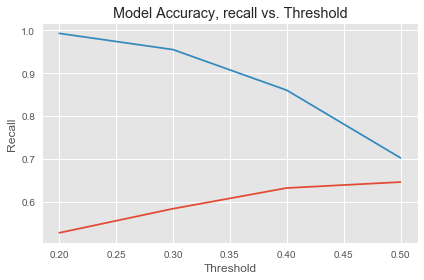

In [42]:
inputNode = 75
hiddenNode = 200
outputNode = 1
learningRate = 0.01
threshold_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

accuracyTest = []
recallTest = []
accuracyTrain = []

for t in threshold_list:
    nn_model = neural_net(inputNode, hiddenNode, outputNode, learningRate, t)
    
    for i in range(X_train_scaled.shape[0]):  #X_train_scaled.shape[0]
        nn_model.train(X_train_scaled[i], y_train[i])
        
    accuResult_test,recallResult_test = nn_model.accu_rate(X_test_scaled, y_test)
    accuracyTest.append(accuResult_test)
    recallTest.append(recallResult_test)
    
    #accuResult_train = nn_model.accu_rate(X_train_scaled, y_train)
    #accuracyTrain.append(accuResult_train)
    
    print('Threshold = {thre} ==> Accuracy = {acc}'.format(thre = t, acc = accuResult_test))
    print('Threshold = {thre} ==> Recall = {recall}'.format(thre = t, recall = recallResult_test))
    print()
    

plt.plot(threshold_list, accuracyTest)
plt.plot(threshold_list, recallTest)

plt.style.use('ggplot')
plt.xlabel('Threshold')
plt.ylabel('Accuracy, Recall')
plt.title('Model Accuracy, recall vs. Threshold')
plt.tight_layout()

#### 6. Build a multi-layer neural network with TensorFlow and train the model with data
A real neural network was developed using Tensorflow. The network employs 2 hidden layers with 500 and 750 hidden nodes, repectively. Sigmoid cross entropy is used to calculate cost. As we can see from the result figure below, we can achieve both accuracy and recall a value of ~80%, which is much better than the self-writtern simple neural network. 

In [43]:
import tensorflow as tf

In [62]:
input_num_units = 75
hidden_num_units_1 = 500 
hidden_num_units_2 = 750
output_num_units = 1
seed = 128

# define placeholders 
x = tf.placeholder(tf.float32, [None, input_num_units]) 
y = tf.placeholder(tf.float32, [None, output_num_units]) 
 
epochs = 5
batch_size = 16 
learning_rate = 0.01 


weights = {
    'hidden_1': tf.Variable(tf.random_normal([input_num_units, hidden_num_units_1], seed=seed)),
    'hidden_2': tf.Variable(tf.random_normal([hidden_num_units_1, hidden_num_units_2], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units_2, output_num_units], seed=seed)) 
} 

biases = {
    'hidden_1': tf.Variable(tf.random_normal([hidden_num_units_1], seed=seed)),
    'hidden_2': tf.Variable(tf.random_normal([hidden_num_units_2], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed)) 
}

In [63]:
hidden_layer_1 = tf.add(tf.matmul(x, weights['hidden_1']), biases['hidden_1']) 
hidden_layer_1 = tf.nn.relu(hidden_layer_1) 

hidden_layer_2 = tf.add(tf.matmul(hidden_layer_1, weights['hidden_2']), biases['hidden_2']) 
hidden_layer_2 = tf.nn.relu(hidden_layer_2)

output_layer = tf.add(tf.matmul(hidden_layer_2, weights['output']), biases['output'])

cost = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits = output_layer, labels = y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

prediction = tf.sigmoid(output_layer)
predicted_class = tf.greater(prediction,0.5)
correct = tf.equal(predicted_class, tf.equal(y,1.0))
accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

In [64]:
def batch_creator(i, batch_size, dataset_length, dataset_x, dataset_y):     
         
    begin = i*batch_size
    stop = (i+1)*batch_size
    
    if (i+1)*batch_size > dataset_length:
        stop = dataset_length
    
    batch_x = dataset_x[begin:stop,:]
    batch_y = dataset_y[begin:stop]
    
    return batch_x, batch_y

In [65]:
with tf.Session() as sess:     
         
    tf.global_variables_initializer().run()          
    
    for epoch in range(epochs):
        
        avg_cost = 0.0         
        total_batch = int(X_train_scaled.shape[0]/batch_size)  
        
        for i in range(total_batch):             
            batch_x, batch_y = batch_creator(i, batch_size, X_train_scaled.shape[0], X_train_scaled, y_train)             
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})                          
            avg_cost += c / total_batch 
            
        print("Epoch:", (epoch+1), "cost =", "{cost}".format(cost=avg_cost))          
    print ("\nTraining complete!")             
    
    pre = sess.run(predicted_class, feed_dict={x: X_test_scaled, y: y_test})
    
    print('Train Accuracy:', accuracy.eval({x: X_train_scaled, y: y_train}))
    print('Test Accuracy:', accuracy.eval({x: X_test_scaled, y: y_test}))

Epoch: 1 cost = 98.801566050341
Epoch: 2 cost = 7.037171743430326
Epoch: 3 cost = 6.439593226521495
Epoch: 4 cost = 6.235088526840132
Epoch: 5 cost = 6.141592614344566

Training complete!
Train Accuracy: 0.816586
Test Accuracy: 0.816305


In [86]:
def met(prediction, label):
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(pre)):

        if (pre[i][0] == True) & (label[i][0] == 1):
            tp += 1

        if (pre[i][0] == False) & (label[i][0] == 0):
            tn += 1

        if (pre[i][0] == True) & (label[i][0] == 0):
            fp += 1

        if (pre[i][0] == False) & (label[i][0] == 1):
            fn += 1
    
    recall = recall = tp/(tp+fn)
    precision = tp/(tp + fp)
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    
    return recall, precision, accuracy
        
rec, prec, accu = met(pre, y_test)
print('Recall: {recall}'.format(recall = rec))
print('Precision: {precision}'.format(precision = prec))
print('Accuracy: {accuracy}'.format(accuracy = accu))

Recall: 0.6444318713906665
Precision: 0.9814297599239363
Accuracy: 0.8163054494425821


Epoch: 1 cost = 98.801566050341
Epoch: 2 cost = 7.037171743430326
Epoch: 3 cost = 6.439593226521495
Epoch: 4 cost = 6.235088526840132
Epoch: 5 cost = 6.141592614344566

Training complete!


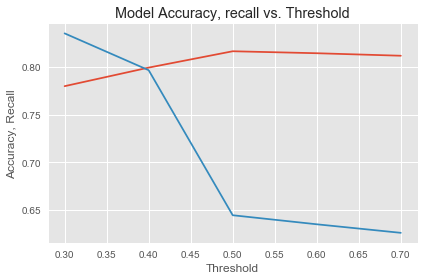

In [87]:
with tf.Session() as sess:     
         
    tf.global_variables_initializer().run()          
    
    for epoch in range(epochs):
        
        avg_cost = 0.0         
        total_batch = int(X_train_scaled.shape[0]/batch_size)  
        
        for i in range(total_batch):             
            batch_x, batch_y = batch_creator(i, batch_size, X_train_scaled.shape[0], X_train_scaled, y_train)             
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})                          
            avg_cost += c / total_batch 
            
        print("Epoch:", (epoch+1), "cost =", "{cost}".format(cost=avg_cost))          
    print ("\nTraining complete!")             
    
    
    accu_list = []
    rec_list = []
    thr_list = []
    for thr in [0.3, 0.4, 0.5, 0.6, 0.7]:
        predicted_class = tf.greater(prediction,thr)
        pre = sess.run(predicted_class, feed_dict={x: X_test_scaled, y: y_test})
        rec, prec, accu = met(pre, y_test)
        
        print('Threshold = {thre} ==> Accuracy = {acc}'.format(thre = thr, acc = accu))
        print('Threshold = {thre} ==> Recall = {recall}'.format(thre = thr, recall = rec))
        print()
        
        accu_list.append(accu)
        rec_list.append(rec)
        thr_list.append(thr)
        
plt.plot(thr_list, accu_list)
plt.plot(thr_list, rec_list)

plt.style.use('ggplot')
plt.xlabel('Threshold')
plt.ylabel('Accuracy, Recall')
plt.title('Model Accuracy, Recall vs. Threshold')
plt.tight_layout()

#### 7. Consider from a different side: Building a regression model for investment return
Now we consider the problem from a different side. Is the above models perfect solution? In the above cassification models, we define a loan to be bad is it is not fully paid. However, if the loan is paid by 99% bfore the borrower stop payment and the intrest is 20%, then the investment return for the lender is still a good number. In the reality, what we care about most is actually the investment return, not the loan is simply good or bad. 

Therefore, we can try to build a regression model, reguardless of the status of the loan, to predict investment return to the lender. If the return can meet our requirement, then the loan can be made, no matter what is the status label. 

Let's re-visit the original data below:

In [88]:
data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 816673 entries, 42535 to 887378
Data columns (total 35 columns):
funded_amnt                    816673 non-null float64
term                           816673 non-null object
int_rate                       816673 non-null float64
grade                          816673 non-null object
emp_length                     816673 non-null object
home_ownership                 816673 non-null object
annual_inc                     816673 non-null float64
verification_status            816673 non-null object
issue_d                        816673 non-null object
loan_status                    816673 non-null object
addr_state                     816673 non-null object
dti                            816673 non-null float64
delinq_2yrs                    816673 non-null float64
inq_last_6mths                 816673 non-null float64
mths_since_last_delinq         816673 non-null float64
mths_since_last_record         816673 non-null float64
open_acc     

In order to explain our new idea, we still assign the data a loan label: 0 for good, 1 for bad as we used in previous classification models.

In addition, we define a new feature "investment return" (IR) as the totoal payment / funded amount. If IR > 1, the lender is making money in the loan, if IR < 1, the lender is losing money in the loan. 

In [89]:
filter_mask = data_reduced['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])
data_finalR = data_reduced[filter_mask]

temp = data_finalR.copy()
temp['loan_label'] = data_finalR['loan_status'].apply(status_label)
data_finalR = temp


temp = data_finalR.copy()
temp['invest_return'] = data_finalR['total_pymnt']/data_finalR['funded_amnt']
data_finalR = temp

As we can see below, for the bad loans (label is 1), the median investment return is below 0.4 which means the lender is losing a significant part of money. This agree with our prediction. For the good loans (label is 0), the median IR is 1.1, which means the lenders are making money. However, carefully looking at the figure, we find that, for bad loans, there are still some loans with IR >1, which correspond to our previous explanation at beginning of this part. For the good loans (fully paid), there are some loans with IR < 1! Why?

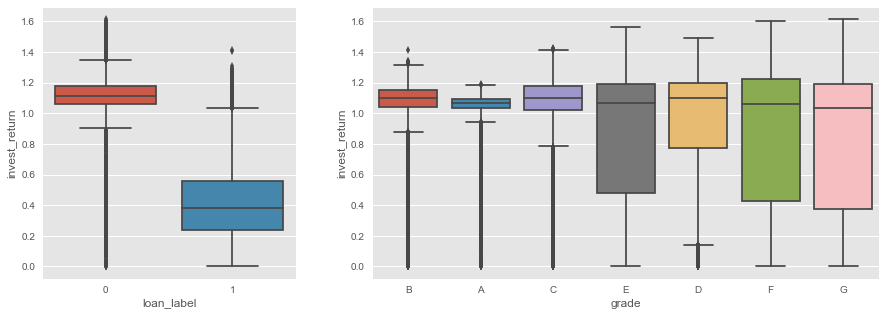

In [90]:
from matplotlib import gridspec

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax1 = plt.subplot(gs[0])
sns.boxplot(ax=ax1, x='loan_label', y='invest_return', data=data_finalR[['loan_label', 'invest_return']])
ax2 = plt.subplot(gs[1])
sns.boxplot(ax=ax2, x='grade', y='invest_return', data=data_finalR[['grade', 'invest_return']])

Carefully examing the below table for good loan with IR < 1, we can see that intrest are still paid, but total payment is less than funded amount. This may be because, especially at beginning months of Lending Club founded, some borrowers got promotion from Lending Club, so that they only paid portion of the loan and Lending Club pay the rest of the full amount (funded amount + toal intrest)

In [34]:
temp_df = data_finalR[data_finalR['loan_label'] == 0]
temp_df = temp_df[temp_df['invest_return'] < 1.0]
temp_df[['total_rec_int', 'int_rate', 'loan_status', 'invest_return', 'total_pymnt', 
                   'funded_amnt']].head(5)

,total_rec_int,int_rate,loan_status,invest_return,total_pymnt,funded_amnt
43033,4098.03,9.67,Fully Paid,0.770704,23121.12,30000.0
43788,2106.12,8.90,Fully Paid,0.762086,12803.04,16800.0
44921,1549.97,13.53,Fully Paid,0.814508,6516.06,8000.0
44945,1937.13,13.53,Fully Paid,0.814408,8144.08,10000.0
47163,1941.59,14.98,Fully Paid,0.831733,7485.60,9000.0


So we define the below function to deal with this issue. Since these loans are labeled as "fully paid", the loan should be safe. If we see this type of loan, we add the total interest to the funed amount to replace the original total amount. Note that this processing still may underestimate the IR since some small portion of interest are covered by Lending Club which is not counted in. 

In [91]:
def calculate_real_payment(df):
    
    if df['loan_label'] == 0:
        if df['total_pymnt'] < df['funded_amnt'] + df['total_rec_int']:
            return df['funded_amnt'] + df['total_rec_int']
        else: 
            return df['total_pymnt']
    else:
        return df['total_pymnt']

In [92]:
data_finalR['real_payment'] = data_finalR[['loan_label', 'total_pymnt', 'funded_amnt', 
                                         'total_rec_int']].apply(calculate_real_payment, axis = 1)

In [93]:
temp = data_finalR.copy()
temp['invest_return'] = data_finalR['real_payment']/data_finalR['funded_amnt']
data_finalR = temp

New IR figure for the modified data is shown below, we don't see any fully paid loan with IR < 1 any more. 

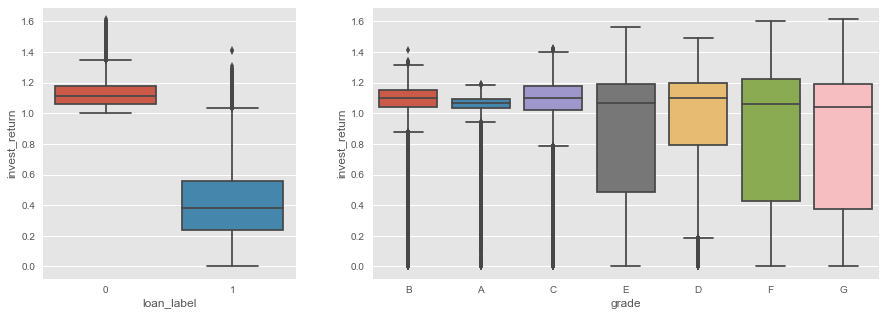

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax1 = plt.subplot(gs[0])
sns.boxplot(ax=ax1, x='loan_label', y='invest_return', data=data_finalR[['loan_label', 'invest_return']])
ax2 = plt.subplot(gs[1])
sns.boxplot(ax=ax2, x='grade', y='invest_return', data=data_finalR[['grade', 'invest_return']])

Some catagorical features still need the same processing as the classification models.

In [95]:
def proc_emp_length(emp_length_val):
    if emp_length_val == '< 1 year' or emp_length_val == 'n/a':
        emp_length_feat = 0.5
    elif emp_length_val == '10+ years':
        emp_length_feat = 10
    else:
        emp_length_feat = float(emp_length_val.rstrip(' years'))
    return emp_length_feat

temp = data_finalR.copy()
temp['employment_length'] = data_finalR['emp_length'].apply(proc_emp_length)
data_finalR = temp
data_finalR.drop('emp_length', axis = 1, inplace=True)

In [96]:
data_finalR['norm_funded_amnt'] = data_finalR['funded_amnt']/data_finalR['annual_inc']

In [97]:
data_finalR.drop(['loan_label', 'loan_status', 'total_pymnt'], axis = 1, inplace = True)
data_finalR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190324 entries, 42538 to 887371
Data columns (total 36 columns):
funded_amnt                    190324 non-null float64
term                           190324 non-null object
int_rate                       190324 non-null float64
grade                          190324 non-null object
home_ownership                 190324 non-null object
annual_inc                     190324 non-null float64
verification_status            190324 non-null object
issue_d                        190324 non-null object
addr_state                     190324 non-null object
dti                            190324 non-null float64
delinq_2yrs                    190324 non-null float64
inq_last_6mths                 190324 non-null float64
mths_since_last_delinq         190324 non-null float64
mths_since_last_record         190324 non-null float64
open_acc                       190324 non-null float64
pub_rec                        190324 non-null float64
revol_bal  

In [98]:
numeric_col = ['funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq', 
                'mths_since_last_record', 'employment_length', 'norm_funded_amnt', 'collections_12_mths_ex_med', 
               'pub_rec', 'open_acc', 'revol_bal', 'revol_util', 'acc_now_delinq', 'mths_since_last_major_derog',
               'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']
categorical_col = ['term', 'grade', 'home_ownership', 'verification_status', 'addr_state']
label_col = ['invest_return']

numeric_short = data_finalR[numeric_col].values
categorical_short = data_finalR[categorical_col].values

In [99]:
print('Numeric features number: ' + str(numeric_short.shape[1]))
print('Categorical features number: ' + str(categorical_short.shape[1]))
print('Total data points: ' + str(numeric_short.shape[0]))

Numeric features number: 19
Categorical features number: 5
Total data points: 190324


In [100]:
XR = numeric_short
yR = data_finalR[label_col].values

for n in range(categorical_short.shape[1]):
    label_enc = preprocessing.LabelEncoder()
    label_val = label_enc.fit_transform(categorical_short[:,n])
    label_val = label_val.reshape(-1, 1)

    onehot_enc = preprocessing.OneHotEncoder()
    category_temp = onehot_enc.fit_transform(label_val)
    category_temp = category_temp.toarray()
    
    XR = np.hstack((XR, category_temp))

In [101]:
XR.shape

(190324, 87)

In [46]:
XR_train, XR_test, yR_train, yR_test = train_test_split(XR, yR, test_size=1.0/3, random_state=42)

In [47]:
min_max_scaler = preprocessing.MinMaxScaler()

XR_train_scaled = min_max_scaler.fit_transform(XR_train)
yR_train = yR_train.reshape((yR_train.shape[0],1))
XR_test_scaled = min_max_scaler.fit_transform(XR_test)
yR_test = yR_test.reshape((yR_test.shape[0],1))

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

linr_model = RandomForestRegressor()
parameters = parameters = {'n_estimators':[10, 20], 'max_depth':[None, 10]}

acc_scorer = metrics.make_scorer(metrics.mean_squared_error)

grid_obj = GridSearchCV(linr_model, param_grid = parameters, cv = 5)
grid_obj = grid_obj.fit(XR_train_scaled, yR_train[:,0])

linr_model = grid_obj.best_estimator_

linr_model.fit(XR_train_scaled, yR_train)
print("Grid scores:")
for params, mean_score, scores in grid_obj.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
            % (mean_score, scores.std() / 2, params))
print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Grid scores:
-0.052 (+/-0.001) for {'max_depth': None, 'n_estimators': 10}
-0.001 (+/-0.002) for {'max_depth': None, 'n_estimators': 20}
0.047 (+/-0.001) for {'max_depth': 10, 'n_estimators': 10}
0.052 (+/-0.001) for {'max_depth': 10, 'n_estimators': 20}



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


As we can see from the below figure, we can use an additional hyper parameter (threshold) to select loans. The size of the data points corresponds to the size the data. Y-value corresponds to the average inverstment return of the selected loans from test data set. As we increase our threshold, average return will increase. but meanwhile, the number of the loans that we can select drop sharply as threshold goes high. 

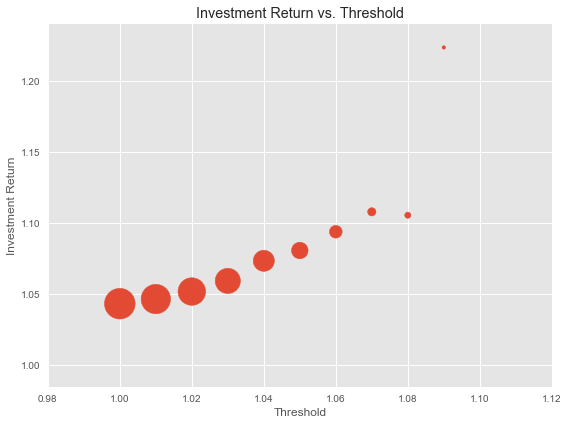

In [108]:
yPred = linr_model.predict(XR_test_scaled)

threshold_list = []
IR_list = []
size = []

for i in range(10):
    
    threshold = 1.0 + i/100.0
    IR = 0
    count = 0
    for k in range(len(yPred)):
        if yPred[k] >= threshold:
            IR += yR_test[k]
            count += 1
    
    IR_list.append(IR/count)
    threshold_list.append(threshold)
    size.append(6*np.sqrt(count))

fig = plt.figure(figsize = (8,6))
plt.style.use('ggplot')
fig = plt.scatter(threshold_list, IR_list, s=size) 
plt.xlim([0.98, 1.12])
plt.xlabel('Threshold')
plt.ylabel('Investment Return')
plt.title('Investment Return vs. Threshold')
plt.tight_layout()

#### Conclusion:
In this project, we use original data provided by Lending Club to build our models using both classification and regression techniques. Our models not only predict whether a coming loan request is good or bad, but also predict the investment return that the lender can get. Combining the classification and regression model, a more confident decision can be made. 

Due to the fact that the project is running on my laptop, not all the features and data can be used to train the model. Also, model optimization cannot be preformed in an time and memory intensive way. Therefore, it time and space allows, the models can be further improved and prediction results can be better.